# <center> Transfer Learning based Clothing Classification 

The goal is to automate the tagging process of clothing items in e-commerce fashion industry. Our framework is based on **Xception model** that utilizes the **imagenet** weights. Currently, it works on 12 clothing items, namely:
- Blazer
- Dress
- Hat
- Longsleeve
- Outwear
- Pants
- Polo
- Shirt
- Shoes
- Shorts
- Skirt
- T-Shirt

### Import required packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from random import randint
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Import dataset

In [2]:
df = pd.read_csv('data.csv')

### Visualize data distribution

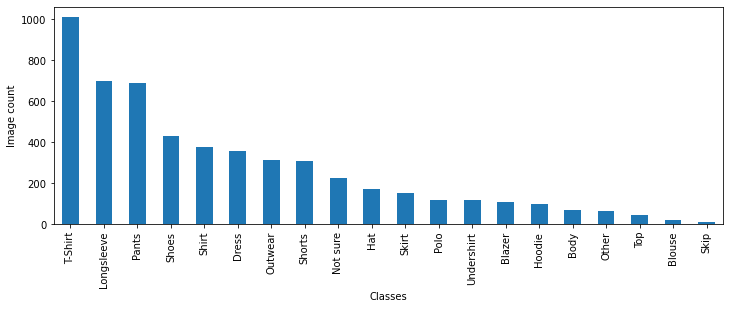

In [3]:
plt.figure(figsize=(12, 4))
df['label'].value_counts(sort=True).plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Image count')
plt.show()

The dataset shows huge class imabalance and would be upsampled & augmented later.

### Prepare data

In [4]:
# Select classes to work on
classes = ['Blazer', 'Dress', 'Hat', 'Longsleeve', 'Outwear', 'Pants',
           'Polo', 'Shirt', 'Shoes', 'Shorts', 'Skirt', 'T-Shirt']

# Remove extra classes
df = pd.concat([df[df.label == classes[i]] for i in range(len(classes))], ignore_index = True)

# Remove extra columns
df = df.drop(['kids', 'sender_id'], axis = 1)

#  Append image extensions
df['image'] = df['image'] + '.jpg'

# Encode categorical labels
df['class'] = LabelEncoder().fit_transform(df['label'].values)

### Display images

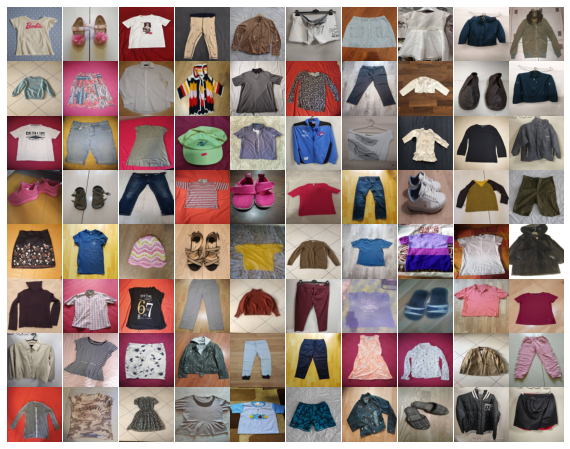

In [5]:
# Display a random set of image data
fig = plt.figure(figsize=(10, 8))
for i in range(80):
    ax = fig.add_subplot(8, 10, i+1)
    ax.imshow(Image.open('dataset/'+ df['image'][randint(1,len(df))]).resize([128,128]))
    ax.axis('off')
    ax.set_aspect('equal')
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Split data into training, validation, and test sets

In [6]:
#  Split the data into training, validation and test set 
# (0.70 : 0.15 : 0.15)
train , test = train_test_split(df, 
                                stratify = df["label"], 
                                test_size = 0.30, 
                                shuffle = True, 
                                random_state = 394)
val, test = train_test_split(test,
                             stratify = test["label"], 
                             test_size = 0.50, 
                             shuffle = True, 
                             random_state = 394)

# Reset dataframe indices
train = train.reset_index(drop = True)
val = val.reset_index(drop = True)
test = test.reset_index(drop = True)

### Balance training data by random sampling

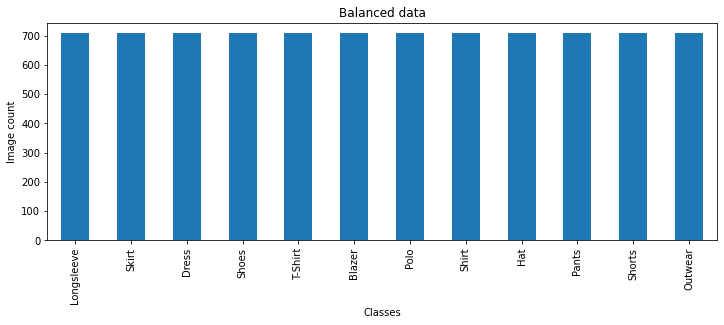

In [7]:
# Define a function to balance training set
def balance_data(df):
    # Number of samples in majority class
    class_size = max(df['label'].value_counts())
    
    # Upsampling
    balanced_df = df.groupby('label').apply(lambda x: x.sample(class_size, replace=True)).reset_index(drop = True)

    return balanced_df

# Balance training set by random sampling
train = balance_data(train)

# Visualize data distribution
plt.figure(figsize=(12, 4))
train['label'].value_counts(sort=True).plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Image count')
plt.title('Balanced data')
plt.show()

### Initialize datastores

In [8]:
# Training data
# Perform image augmentation on training images
train_datagen = ImageDataGenerator(horizontal_flip = True,
                                   vertical_flip = False,
                                   zoom_range = 0.1,
                                   rotation_range = 20,
                                   width_shift_range = 5,
                                   height_shift_range = 5,
                                   shear_range = 5,
                                   fill_mode="nearest",
                                   preprocessing_function = preprocess_input)
train_ds = train_datagen.flow_from_dataframe(train,
                                             directory = 'dataset/',
                                             x_col = "image",
                                             y_col = "label",
                                             target_size = (256, 256),
                                             batch_size = 32,
                                             shuffle = True,
                                             seed = 394)

# Validation data
validation_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
val_ds = validation_datagen.flow_from_dataframe(val,
                                                directory = 'dataset/',
                                                x_col = "image",
                                                y_col = "label",
                                                target_size = (256, 256),
                                                batch_size = 32,
                                                shuffle = True,
                                                seed = 394)
# Test data
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
test_ds = test_datagen.flow_from_dataframe(test,
                                           directory = 'dataset/',
                                           x_col = "image",
                                           y_col = None,
                                           class_mode = None,
                                           target_size = (256, 256),
                                           batch_size = 32,
                                           shuffle = False,
                                           seed = 394)

Found 8496 validated image filenames belonging to 12 classes.
Found 711 validated image filenames belonging to 12 classes.
Found 712 validated image filenames.


### Training Classifier

In [9]:
def classifier():
    # Import xception model and imagenet weights
    xception_model = Xception(weights = 'imagenet',
                              input_shape = (256, 256, 3),
                              include_top = False)
    xception_model.trainable = False
    
    # Input layer
    inputs = keras.Input(shape = (256, 256, 3))
    
    # Hidden layers
    layer_a = xception_model(inputs, training = False)
    layer_b = keras.layers.GlobalAveragePooling2D()(layer_a)
    layer_c = keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-3))(layer_b)
    layer_d = keras.layers.Dropout(0.3)(layer_c)

    # Output layer
    outputs = keras.layers.Dense(12)(layer_d)
    
    # Build and compile the model
    model = keras.Model(inputs, outputs, name='Classification_model')
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.0005),
                  loss = keras.losses.CategoricalCrossentropy(from_logits = True),
                  metrics = ["accuracy"])
    return model

# Create model instance
model = classifier()

# Interpret model parameters
model.summary()

Model: "Classification_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                1548      
Total params: 21,125,300
Trainable params: 263,820
Non-trainable params: 20,861,480
____________________________

### Model training

In [10]:
training = model.fit(train_ds,
                     validation_data = val_ds,
                     steps_per_epoch = len(train)//32,
                     epochs = 20,
                     verbose = 1)

Epoch 1/20
265/265 [==============================] - 1187s 4s/step - loss: 1.0210 - accuracy: 0.6695 - val_loss: 0.6237 - val_accuracy: 0.7904
Epoch 2/20
265/265 [==============================] - 1190s 4s/step - loss: 0.6156 - accuracy: 0.7940 - val_loss: 0.4687 - val_accuracy: 0.8481
Epoch 3/20
265/265 [==============================] - 1072s 4s/step - loss: 0.4879 - accuracy: 0.8391 - val_loss: 0.4461 - val_accuracy: 0.8579
Epoch 4/20
265/265 [==============================] - 1036s 4s/step - loss: 0.4199 - accuracy: 0.8614 - val_loss: 0.3702 - val_accuracy: 0.8776
Epoch 5/20
265/265 [==============================] - 1049s 4s/step - loss: 0.3828 - accuracy: 0.8780 - val_loss: 0.3448 - val_accuracy: 0.8889
Epoch 6/20
265/265 [==============================] - 1056s 4s/step - loss: 0.3294 - accuracy: 0.8922 - val_loss: 0.2978 - val_accuracy: 0.8987
Epoch 7/20
265/265 [==============================] - 1053s 4s/step - loss: 0.3003 - accuracy: 0.9068 - val_loss: 0.2990 - val_accuracy:

### Model performance

In [11]:
score_train = model.evaluate(train_ds, verbose=1)
print('Training Loss: ' +"{:.3f}".format(score_train[0]))
print('Training Accuracy: ' +"{:.3f}".format(score_train[1]*100) + '%\n')

score_val = model.evaluate(val_ds, verbose=1)
print('Validation Loss: ' +"{:.3f}".format(score_val[0]))
print('Validation Accuracy: ' +"{:.3f}".format(score_val[1]*100) + '%')

266/266 [==============================] - 1326s 5s/step - loss: 0.1076 - accuracy: 0.9681
Training Loss: 0.107
Training Accuracy: 96.816%

23/23 [==============================] - 76s 3s/step - loss: 0.1608 - accuracy: 0.9376
Validation Loss: 0.161
Validation Accuracy: 93.762%


### Save the trained model

In [12]:
model.save('trained_model.h5')

### Learning curves

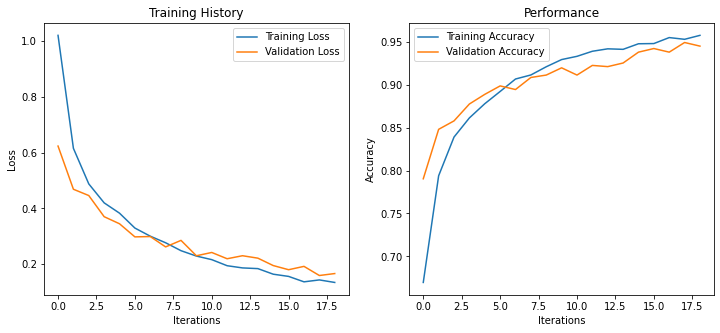

In [13]:
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(training.history['loss'], label = 'Training Loss')
ax1.plot(training.history['val_loss'], label = 'Validation Loss')
ax1.set_title('Training History')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.plot(training.history['accuracy'], label = 'Training Accuracy')
ax2.plot(training.history['val_accuracy'], label = 'Validation Accuracy')
ax2.set_title('Performance')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

### Performance evaluation

23/23 [==============================] - 111s 5s/step
Test Accuracy: 89.75%


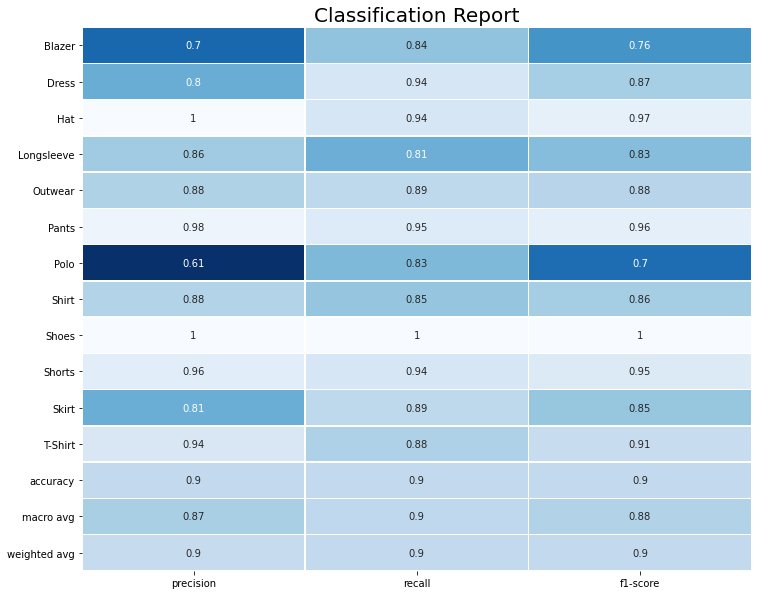

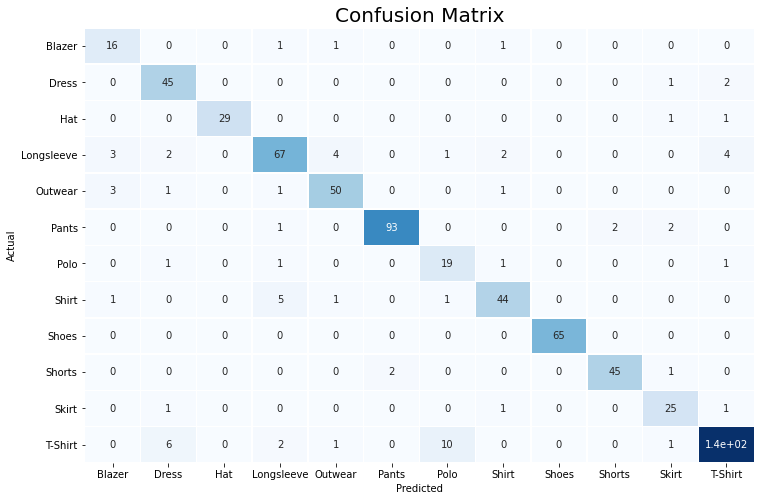

In [14]:
def Evaluation(true_labels, predicted_labels, labels):
    # Compute accuracy
    accuracy = accuracy_score(true_labels, predicted_labels)
    
    # Generate and plot classification report
    report = classification_report(true_labels, predicted_labels, target_names=labels, output_dict=True)
    plt.figure(figsize = (12, 10))
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, linewidths=0.5, cmap='Blues_r', cbar=False,
                xticklabels=True, yticklabels=True)
    plt.title('Classification Report', fontsize = 20)
    
    # Generate and plot confusion matrix
    CM = confusion_matrix(true_labels, predicted_labels)
    
    plt.figure(figsize = (12, 8))
    sns.heatmap(CM, annot=True, cbar=False, yticklabels=labels, linewidths=0.5, xticklabels=labels, cmap='Blues')
    plt.title('Confusion Matrix', fontsize = 20)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    
    return accuracy, report, CM


# Test and evaluate the model
pred_labels = np.argmax(model.predict(test_ds, verbose = 1), axis=1)
true_labels = test['class']
labels = np.unique(test['label'].values)

Accuracy, Report, Confusion_Matrix = Evaluation(true_labels, pred_labels, labels)
print('Test Accuracy: ' + "{:.2f}".format(Accuracy*100) + '%')

Done!